# Exercise Sheet 03: Item response theory and performance factors analysis

**Introduction to Data Mining WS24/25**  
**Bielefeld University**  
**Alina Deriyeva, Adia Khalid, Benjamin Paaßen**  
**Exercise Sheet Publication Date: 2024-11-18**  
**Exercise Sheet Submission Deadline: Friday, 2024-11-29, noon (i.e. 12:00), via moodle**

**NOTE** The use of language models/AI tools is permitted under three conditions
1. transparency: you tell us that you used them
2. accountability: you take full responsibility for the submission, can explain and defend it
3. privacy: you do not transmit any private information to any external tool

We also appreciate it if you link to a chatlog of the interaction with the language model/AI tool for research purposes.

### Task 03.01

Let $X$ be a random variable that expresses whether a student gets a task right or wrong, let $B$ be a random variable expressing the difficulty of the task, and let $\Theta$ be a random variable expressing the students' ability. Further, let's assume a one-parameter IRT model, that is:

\begin{equation}
p_{X|B,\Theta}(1|b,\theta) = \frac{1}{1 + \exp[-(\theta-b)]}.
\end{equation}

Finally, assume that $\Theta$ is standard normally distributed.

1. Using the law of total probability, write down the expression for $p_{X|B}(1|b)$.
2. Use the following approximation ([Crooks, 2007](https://threeplusone.com/pubs/on_logistic_normal.pdf)) to find a closed-form expression for $p_{X|B}(1|b)$:
\begin{equation}
\int_{-\infty}^\infty \frac{1}{1 + \exp(-x)} \cdot N(x|y,1) dx \approx \frac{1}{1 + \exp(-\sqrt{1 + \frac{\pi}{8}} \cdot y)}
\end{equation}
where $N(x|y, 1)$ denotes the Gaussian density for $x$ with mean $y$ and standard deviation $1$.
3. Let $q$ be the rate of actual students passing the task. What is the value of $b$ one should set to get $p_{X|B}(x|b) = q$?


**ANSWER:** PLEASE PROVIDE LATEX CODE OR AN IMAGE OF YOUR DERIVATION HERE

## Preamble: Data set

The file `sheet03_data.csv` contains fictional data of a class of students completing a set of tasks. Each row indicates a student, each column indicates a task. Each task is only graded as 'passed' (1) or 'failed' (0).

The following code loads this raw data and prints it.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = np.loadtxt('sheet03_data.csv', skiprows = 1, delimiter = '\t', dtype=int)
N, m = X.shape
print(X)

Matplotlib is building the font cache; this may take a moment.


[[1 1 0 ... 0 1 0]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 1 1 1]
 [1 0 0 ... 0 0 0]]


### Task 03.02

Before we apply any advanced data mining, let us compute some basic statistics to get a sense of the data.

Provide a bar plot with the task index on the x axis and the pass rate on the y axis. Don't forget to label your axes.

Provide a second bar plot with the student index on the x axis and the pass rate on the y axis. Don't forget to label your axes.

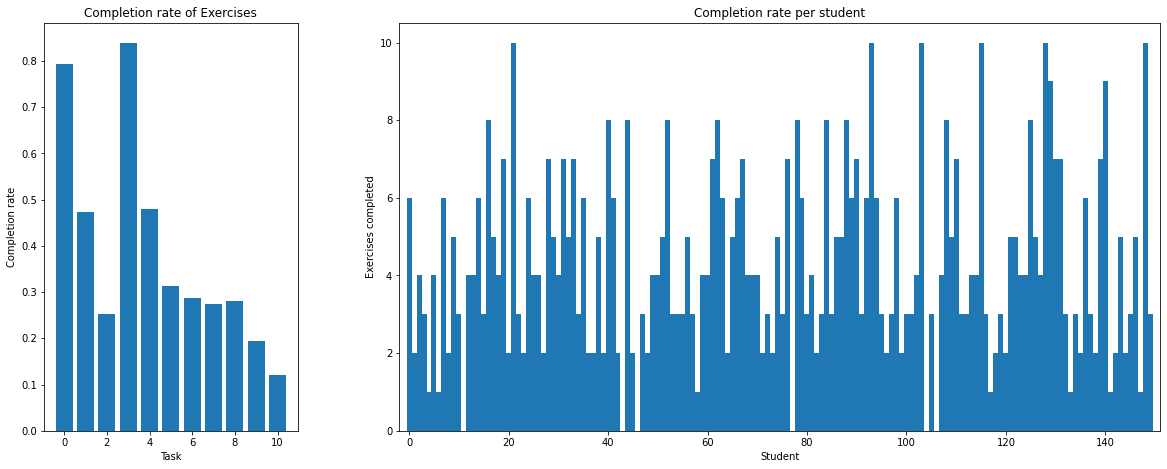

In [90]:
task_completion_rate = np.sum(X, axis=0)/N
success_per_student = np.sum(X, axis=1)

fig, (exercise_plot, student_plot) = plt.subplots(1, 2, width_ratios=[1,3], figsize=(20, 7.5))

student_plot.bar(range(N), success_per_student, width=1)
exercise_plot.bar(range(m), task_completion_rate)

student_plot.set_title("Completion rate per student")
student_plot.set_xlabel('Student')
student_plot.set_ylabel('Exercises completed')
student_plot.set_xlim([-2,N+1])

exercise_plot.set_title('Completion rate of Exercises')
exercise_plot.set_xlabel('Task')
exercise_plot.set_ylabel('Completion rate')

plt.show()

## Item Response Theory

Now, we want to fit item response theory models to our data. We will start with a 1-parameter model and then continue with a 2-parameter model.

For the former, we will use the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) interface from scikit-learn. For the latter, we will use the [girth](https://github.com/eribean/girth) software package.

### Task 03.03

Right now, our data is in the form of an $N \times m$ matrix, where $N$ is the number of students and $m$ is the number of tasks. To plug this data into logistic regression, we need to convert it to a different format.

1. Prepare a $(N \cdot m) \times (N + m)$ matrix `Xlogreg` where each row represents a student-task combination. All entries are zero except for the entries `Xlogreg[i*m+j, i] = 1`, `Xlogreg[i*m+j, N+j] = 1` for all $i \in \{0, \ldots, N-1\}$ and all $j \in \{0, \ldots, m-1\}$. This is the feature matrix for our logistic regression.
2. Prepare a vector `ylogreg` with $N \cdot m$ entries where each entry represents a student-task combination and `ylogreg[i*m+j] = X[i, j]` for all $i \in \{0, \ldots, N-1\}$ and all $j \in \{0, \ldots, m-1\}$.

In [105]:
Xlogreg = np.zeros((N*m, N+m))
ylogreg = np.zeros(N*m)
for i in range(N):
    for j in range(m):
        Xlogreg[i*m+j][i] = 1
        Xlogreg[i*m+j][N+j] = 1
        ylogreg[i*m+j] = X[i][j]
        
print(Xlogreg) 
print(ylogreg)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[1. 1. 0. ... 0. 0. 0.]


### Task 03.04

Use the new format of the data to train an [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with `penalty = 'l2'`, `C = 1.0`, and `fit_intercept = False`.

Report the accuracy of the model by printing the output of the `score` function of the model.

In [123]:
import sklearn

lr_model = sklearn.linear_model.LogisticRegression(penalty="l2", C=1.0, fit_intercept=False)
lr_model.fit(Xlogreg, ylogreg)
print(lr_model.score(Xlogreg, ylogreg))

0.7963636363636364


### Task 03.05

The learned parameters of the model are stored in the `coef_` attribute. The first $N$ parameters represent the estimated student abilities, the last $m$ parameters represent the negative (!) estimated task difficulties.

Extract abilities and task difficulties.

Provide a scatter plot with estimated task difficulties on the x axis and pass rates on the y axis. Don't forget to label your axes.

Provide a scatter plot with estimated student abilities on the x axis and pass rates on the y axis. Don't forget to label your axes.

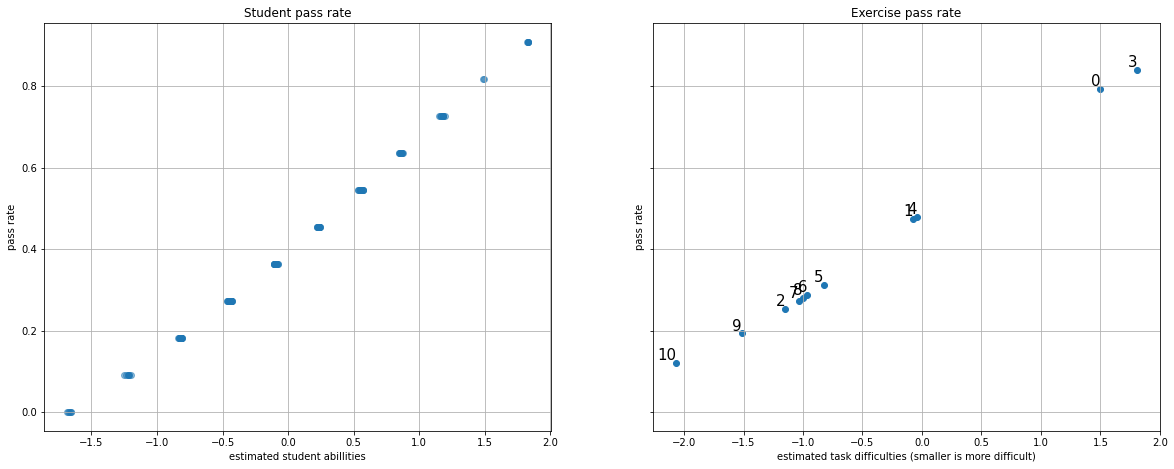

In [135]:
def add_jitter(data, scale=0.01):
    return data + np.random.normal(0, scale, data.shape)

est_student_abilities = lr_model.coef_[:,:N].flatten()
est_task_difficulties = lr_model.coef_[:,N:].flatten()
exercise_pass_rates = np.sum(X, axis=0)/N
student_pass_rates = np.sum(X, axis=1)/m

# again: no idea why only specific values get plotted and not all of them.
# This is due to multiple students being classified to the exact same "ability" score, meaning their points overlap.
# Which is probably a limitation of the linear regression model. We can see this if we add jitter to the points.

fig, (student_plot, exercise_plot) = plt.subplots(1, 2, sharey=True, figsize=(20, 7.5))
exercise_plot.scatter(est_task_difficulties, exercise_pass_rates)

# For visual clarity only!
#est_student_abilities = add_jitter(est_student_abilities)
#student_pass_rates = add_jitter(student_pass_rates)

student_plot.scatter(add_jitter(est_student_abilities), student_pass_rates, alpha=0.5)

student_plot.set_title("Student pass rate")
student_plot.set_ylabel("pass rate")
student_plot.set_xlabel("estimated student abillities")
student_plot.grid(True)

exercise_plot.set_title("Exercise pass rate")
exercise_plot.set_ylabel("pass rate")
exercise_plot.set_xlabel("estimated task difficulties (smaller is more difficult)")
exercise_plot.grid(True)

for i in range(len(exercise_pass_rates)):
    plt.text(
        est_task_difficulties[i],
        exercise_pass_rates[i],
        str(i),
        fontsize=15,
        ha='right',
        va='bottom'
    )

plt.show()

### Task 03.06

Plot the item characteristic curve for the second task (item index 1) according to your IRT model. To do so, sample 61 abilities via the `np.linspace` function in the range $[-3, +3]$ and plot the value of the function

\begin{equation*}
p(x = 1|\theta, b_2) = \frac{1}{1 + \exp(-(\theta - b_2))}
\end{equation*}

where $b_2$ is the difficulty of the second task and $\theta$ is the ability.

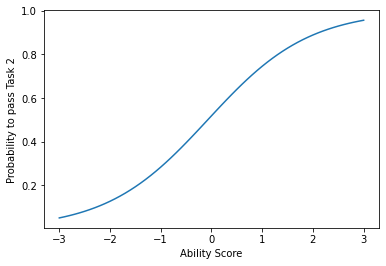

In [144]:
sampled_abilities = np.linspace(-3, 3, num=61)

item_char_curve_y = 1/(1+np.exp(-(sampled_abilities-est_task_difficulties[1])))

plt.plot(sampled_abilities, item_char_curve_y)
plt.xlabel('Ability Score')
plt.ylabel('Probability to pass Task 2')
plt.show()

### Task 03.07

To validate the item characteristic curve of item 2 (see Task 03.05), provide a plot of the pass rate of students within a certain range of abilities. In particular, compute the pass rates for students with an ability between -2.5 and -1.5, between -1.5 and -0.5, between -0.5 and +0.5, beween +0.5 and +1.5, and between +1.5 and +2.5. Then, plot these values on the y axis versus x values -2, -1, 0, +1, +2.

Plot the item characteristic curve from task 03.05 as well.

Compare the pass rate curve to the item characteristic curve. Are they similar? What is different?

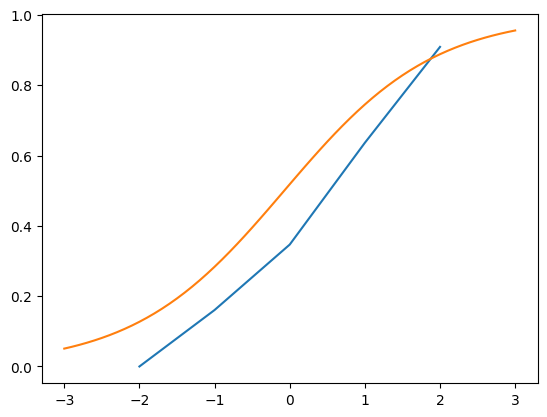

In [57]:
categorized_pass_rates = [0, 0, 0, 0, 0]
num_students_per_category = [0, 0, 0, 0, 0]

for i in range(len(est_student_abilities)):
    if est_student_abilities[i] < -1.5:
        categorized_pass_rates[0] += student_pass_rates[i]
        num_students_per_category[0] += 1
    elif est_student_abilities[i] < -0.5:
        categorized_pass_rates[1] += student_pass_rates[i]
        num_students_per_category[1] += 1
    elif est_student_abilities[i] < 0.5:
        categorized_pass_rates[2] += student_pass_rates[i]
        num_students_per_category[2] += 1
    elif est_student_abilities[i] < 1.5:
        categorized_pass_rates[3] += student_pass_rates[i]
        num_students_per_category[3] += 1
    else:
        categorized_pass_rates[4] += student_pass_rates[i]
        num_students_per_category[4] += 1

for i in range(len(categorized_pass_rates)):
    categorized_pass_rates[i] = categorized_pass_rates[i]/num_students_per_category[i]
    
plt.plot([-2, -1, 0, 1, 2], categorized_pass_rates)
plt.plot(sampled_abilities, item_char_curve_y)

**ANSWER:** 
Comparing the item characteristic curve with the pass rate curve, there are some similarities visible: with higher abilities, wether they are sampled or estimated, the pass rate, or in case of the item characteristic curve, the probablility of succeeding gets higher as well. Furthermore, both curves rise faster at the center than at the lower end. The curves seem to be not too far apart as well.<br>
Though it is hard to really say if those curves are really related to each other, just by looking at them, there definitely are similarities. A valid hypothesis would be that with more data for the model, meaning more students or more exercises, the curves might approach each other.


### Preamble: Knowledge Tracing Data set

Consider the data set in `kt_data.csv`. This data set contains the exercise results for a population of fictional students and two skills.

Each row corresponds to one attempt of one student on an exercise. The first column indicates the student index $i$, the second column the time $t$, the third column the exercise index $j$, the fourth whether this exercise needs the first skill (0 if no, 1 if yes), the fifth column whether this exercise needs the second skill (0 if no, 1 if yes), and the sixth column the outcome of the attempt: 0 for a failure, 1 for a success.

The following code loads the raw data and prints it.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = np.loadtxt('kt_data.csv', skiprows = 1, delimiter = '\t', dtype=int)
print(X)

[[ 0  0  1  1  0  0]
 [ 0  1  1  1  0  0]
 [ 0  2  1  1  0  0]
 [ 0  3  2  0  1  0]
 [ 0  4  1  1  0  0]
 [ 0  5  4  1  1  1]
 [ 0  6  3  0  1  0]
 [ 0  7  4  1  1  1]
 [ 0  8  1  1  0  1]
 [ 0  9  4  1  1  1]
 [ 0 10  2  0  1  1]
 [ 1  0  4  1  1  1]
 [ 1  1  2  0  1  0]
 [ 1  2  3  0  1  1]
 [ 1  3  2  0  1  1]
 [ 1  4  2  0  1  1]
 [ 1  5  4  1  1  1]
 [ 1  6  3  0  1  1]
 [ 1  7  2  0  1  1]
 [ 1  8  0  1  0  1]
 [ 2  0  5  1  1  0]
 [ 2  1  2  0  1  0]
 [ 2  2  3  0  1  1]
 [ 2  3  0  1  0  1]
 [ 2  4  3  0  1  0]
 [ 2  5  4  1  1  1]
 [ 2  6  4  1  1  1]
 [ 2  7  0  1  0  1]
 [ 2  8  0  1  0  1]
 [ 2  9  1  1  0  1]
 [ 3  0  1  1  0  0]
 [ 3  1  3  0  1  0]
 [ 3  2  5  1  1  0]
 [ 3  3  3  0  1  0]
 [ 3  4  5  1  1  1]
 [ 3  5  3  0  1  0]
 [ 3  6  3  0  1  0]
 [ 3  7  3  0  1  1]
 [ 3  8  4  1  1  1]
 [ 3  9  0  1  0  1]
 [ 3 10  1  1  0  1]
 [ 4  0  4  1  1  0]
 [ 4  1  2  0  1  0]
 [ 4  2  0  1  0  0]
 [ 4  3  4  1  1  0]
 [ 4  4  0  1  0  1]
 [ 4  5  2  0  1  1]
 [ 4  6  0  1

## Performance Factors analysis


Recall the form of a performance factors analysis model: The logit-probability that student $i$ achieves a success at time step $t$, given all their previous successes and failures, is modelled as

\begin{equation}
\sum_{k \in \mathcal{K}_{i, t}} \gamma_k \cdot s_{i, k, t} + \rho_k \cdot f_{i, k, t} + \beta_k
\end{equation}

where $\mathcal{K}_{i, t}$ is the set of skills needed for the exercise student $i$ attempts at time step $t$, where $s_{i, k, t}$ is the number of past successes of student $i$ on skill $k$ before time step $t$, where $f_{i, k, t}$ is the number of past failures of student $i$ on skill $k$ before time step $t$, and where $\gamma_k$, $\rho_k$, and $\beta_k$ are the parameters of the model.

Note that this is, essentially, a logistic regression model, where $s_{i, k, t}$ and $f_{i, k, t}$ are the features and $x_{i, t}$ is the target to be predicted.


### Task 03.08

Find a formula for $\theta_{i, k, t}$, meaning the amount of skill that student $i$ has achieved in skill $k$ at time $t$ in the PFA model.

**ANSWER:** PLEASE PROVIDE LATEX CODE OR AN IMAGE OF YOUR DERIVATION HERE

### Task 03.09

Convert the data set into a feature matrix `Xlogreg` for a logistic [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model, where each row corresponds to one attempt of one student $i$ on an exercise (just as in the raw data) and where the columns are $s_{i, 1, t}$, $f_{i, 1, t}$, 1, $s_{i, 2, t}$, $f_{i, 2, t}$, and 1 again, meaning the past successes and the past failures for the first and the second skill for student $i$ at time $t$.

HOWEVER make sure to set the first three columns to zero in every row where the exercise that student $i$ attempts at time $t$ does not involve the first skill and the last three columns to zero in every row where the exercise does not involve the second skill.

**HINT:** Look again at the video in moodle for an example of this process. While this task is not hard to program, per se, the devil is in the details.

### Task 03.10

Use the matrix `Xlogreg` from Task 03.09 and the last column of `X` (as targets) to train an [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with `penalty = 'l2'`, `fit_intercept = False`, and `C = 1.0`.

Report the accuracy of the model by printing the output of the `score` function of the model.

### Task 03.11

Print the trained parameters of the model in the following format:

```
gamma_1 = %g
rho_1   = %g
beta_1  = %g
gamma_2 = %g
rho_2   = %g
beta_2  = %g
```

Given these parameters, compute the amount of the first skill for a student with 3 past successes and 1 past failure and print it.

### Task 03.12

For each student in the data set, provide a plot with time on the x axis and the predicted success probability of the performance factors analysis model on the y axis.

### Task 03.13

In the previous task, you probably noticed that the predicted success probability of the performance factors analysis model sometimes drops for later timesteps. Explain this finding.

**ANSWER:** 